In [61]:
# This file reads in a csv of hourly normals taken from https://www.ncei.noaa.gov/cdo-web/search from Seatac airport for 2010.
# Then preprocesses data before feed hourly temperature normals, and hourly wind direction it to a multivariable LSTM model
# to train and use to forecast the temperature.

from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import load_model
from keras.losses import MeanSquaredError
from keras.models import Sequential
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib

In [62]:
# Load data

weather = pd.read_csv("3588306.csv", index_col="DATE")

In [63]:
weather

,STATION,NAME,HLY-PRES-NORMAL,HLY-TEMP-NORMAL,HLY-WIND-1STDIR
DATE,,,,,
01-01T01:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",1.0,39.2,5
01-01T02:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",1.0,39.0,5
01-01T03:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",1.0,38.9,5
01-01T04:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",1.0,38.8,5
01-01T05:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",1.0,38.7,5
...,...,...,...,...,...
12-31T19:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",1.0,40.7,5
12-31T20:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",1.0,40.5,5
12-31T21:00:00,USW00024233,"SEATTLE TACOMA INTERNATIONAL AIRPORT, WA US",1.0,40.2,5


In [64]:
# Remove unused data points

del weather["HLY-PRES-NORMAL"]
del weather["STATION"]
del weather["NAME"]

In [65]:
weather

,HLY-TEMP-NORMAL,HLY-WIND-1STDIR
DATE,,
01-01T01:00:00,39.2,5
01-01T02:00:00,39.0,5
01-01T03:00:00,38.9,5
01-01T04:00:00,38.8,5
01-01T05:00:00,38.7,5
...,...,...
12-31T19:00:00,40.7,5
12-31T20:00:00,40.5,5
12-31T21:00:00,40.2,5


In [66]:
# Check for NAN vals

weather.apply(pd.isnull).sum()

HLY-TEMP-NORMAL    0
HLY-WIND-1STDIR    0
dtype: int64

<Axes: xlabel='DATE'>

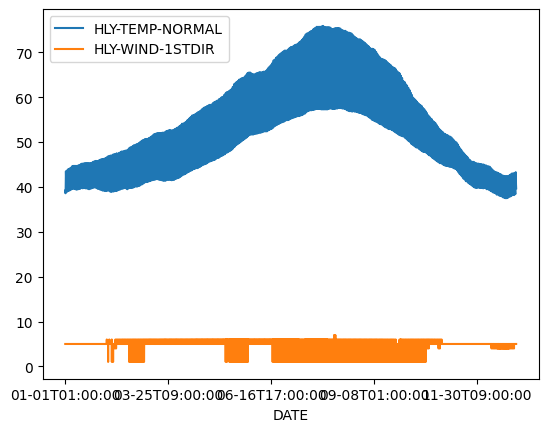

In [67]:
# Take a look at data using

weather[["HLY-TEMP-NORMAL", "HLY-WIND-1STDIR"]].plot()

In [75]:
# Function to create sliding window of past data points to feed model
# [[[t1, ws1], [t2, ws2], ... [t10, ws10]]] [t11]

def df_to_X_y(df, window_size=10):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [69]:
# Generate data, X is the window we use with each row being 10 arrays with 2 variable each to predict the temp of the same row in y

X, y = df_to_X_y(weather)
X.shape, y.shape

((8749, 10, 2), (8749,))

In [70]:
# Break up data into training, validation, and test sets

X_train, y_train = X[:7700], y[:7700]
X_val, y_val = X[7700:8200], y[7700:8200]
X_test, y_test = X[8200:], y[8200:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((7700, 10, 2), (7700,), (500, 10, 2), (500,), (549, 10, 2), (549,))

In [72]:
# Processing temps into standardized normal distribution

weather_training_mean = np.mean(X_train[:, :, 0])
weather_training_std = np.std(X_train[:, :, 0])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - weather_training_mean) / weather_training_std 
  return X

In [73]:
preprocess(X_train)
preprocess(X_val)
preprocess(X_test)

array([[[-1.18187255,  5.        ],
        [-1.22479284,  5.        ],
        [-1.25698307,  5.        ],
        ...,
        [-1.33209359,  5.        ],
        [-1.40720411,  5.        ],
        [-1.42866426,  5.        ]],

       [[-1.22479284,  5.        ],
        [-1.25698307,  5.        ],
        [-1.26771314,  5.        ],
        ...,
        [-1.40720411,  5.        ],
        [-1.42866426,  5.        ],
        [-1.45012441,  5.        ]],

       [[-1.25698307,  5.        ],
        [-1.26771314,  5.        ],
        [-1.31063344,  5.        ],
        ...,
        [-1.42866426,  5.        ],
        [-1.45012441,  5.        ],
        [-1.47158455,  5.        ]],

       ...,

       [[-1.32136351,  5.        ],
        [-1.20333269,  5.        ],
        [-1.12822217,  5.        ],
        ...,
        [-1.34282366,  5.        ],
        [-1.37501388,  5.        ],
        [-1.39647403,  5.        ]],

       [[-1.20333269,  5.        ],
        [-1.12822217,  5.  

In [43]:
# Define LSTM model using using window size 10 for 2 variable inputs

model = Sequential()
model.add(InputLayer((10, 2)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17152     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17681 (69.07 KB)
Trainable params: 17681 (69.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
# Create model checkpoint to save best model, then finally compile model

cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [45]:
# Train model

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp])

Epoch 1/50
218/241 [==========================>...] - ETA: 0s - loss: 2932.0393 - root_mean_squared_error: 54.1483INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 3s 9ms/step - loss: 2930.7556 - root_mean_squared_error: 54.1365 - val_loss: 1719.7119 - val_root_mean_squared_error: 41.4694
Epoch 2/50
221/241 [==========================>...] - ETA: 0s - loss: 2650.6987 - root_mean_squared_error: 51.4849INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 2629.7380 - root_mean_squared_error: 51.2810 - val_loss: 1362.2479 - val_root_mean_squared_error: 36.9086
Epoch 3/50
222/241 [==========================>...] - ETA: 0s - loss: 2217.0842 - root_mean_squared_error: 47.0859INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 2206.3442 - root_mean_squared_error: 46.9717 - val_loss: 1104.8077 - val_root_mean_squared_error: 33.2386
Epoch 4/50
225/241 [===========================>..] - ETA: 0s - loss: 1927.1296 - root_mean_squared_error: 43.8991INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 9ms/step - loss: 1918.8268 - root_mean_squared_error: 43.8044 - val_loss: 916.0043 - val_root_mean_squared_error: 30.2656
Epoch 5/50
223/241 [==========================>...] - ETA: 0s - loss: 1687.0874 - root_mean_squared_error: 41.0742INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 1680.6123 - root_mean_squared_error: 40.9953 - val_loss: 756.2267 - val_root_mean_squared_error: 27.4996
Epoch 6/50
221/241 [==========================>...] - ETA: 0s - loss: 1465.2438 - root_mean_squared_error: 38.2785INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 1455.9634 - root_mean_squared_error: 38.1571 - val_loss: 601.6019 - val_root_mean_squared_error: 24.5276
Epoch 7/50
221/241 [==========================>...] - ETA: 0s - loss: 1250.4032 - root_mean_squared_error: 35.3610INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 9ms/step - loss: 1248.8114 - root_mean_squared_error: 35.3385 - val_loss: 471.5176 - val_root_mean_squared_error: 21.7145
Epoch 8/50
237/241 [============================>.] - ETA: 0s - loss: 1066.2075 - root_mean_squared_error: 32.6528INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 1063.8021 - root_mean_squared_error: 32.6160 - val_loss: 356.5813 - val_root_mean_squared_error: 18.8834
Epoch 9/50
225/241 [===========================>..] - ETA: 0s - loss: 890.5687 - root_mean_squared_error: 29.8424INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 887.9196 - root_mean_squared_error: 29.7980 - val_loss: 251.6715 - val_root_mean_squared_error: 15.8642
Epoch 10/50
218/241 [==========================>...] - ETA: 0s - loss: 739.0978 - root_mean_squared_error: 27.1864INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 728.5549 - root_mean_squared_error: 26.9918 - val_loss: 168.1217 - val_root_mean_squared_error: 12.9662
Epoch 11/50
221/241 [==========================>...] - ETA: 0s - loss: 594.6999 - root_mean_squared_error: 24.3865INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 590.2432 - root_mean_squared_error: 24.2949 - val_loss: 102.7565 - val_root_mean_squared_error: 10.1369
Epoch 12/50
223/241 [==========================>...] - ETA: 0s - loss: 473.5963 - root_mean_squared_error: 21.7623INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 9ms/step - loss: 470.8330 - root_mean_squared_error: 21.6987 - val_loss: 54.8113 - val_root_mean_squared_error: 7.4035
Epoch 13/50
221/241 [==========================>...] - ETA: 0s - loss: 374.3111 - root_mean_squared_error: 19.3471INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 370.2402 - root_mean_squared_error: 19.2416 - val_loss: 23.4047 - val_root_mean_squared_error: 4.8378
Epoch 14/50
241/241 [==============================] - ETA: 0s - loss: 288.1680 - root_mean_squared_error: 16.9755INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 288.1680 - root_mean_squared_error: 16.9755 - val_loss: 7.1745 - val_root_mean_squared_error: 2.6785
Epoch 15/50
221/241 [==========================>...] - ETA: 0s - loss: 224.9227 - root_mean_squared_error: 14.9974INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 9ms/step - loss: 223.6150 - root_mean_squared_error: 14.9538 - val_loss: 4.0190 - val_root_mean_squared_error: 2.0047
Epoch 16/50
241/241 [==============================] - 0s 2ms/step - loss: 175.0508 - root_mean_squared_error: 13.2307 - val_loss: 11.2178 - val_root_mean_squared_error: 3.3493
Epoch 17/50
241/241 [==============================] - 0s 2ms/step - loss: 140.4095 - root_mean_squared_error: 11.8495 - val_loss: 25.7103 - val_root_mean_squared_error: 5.0705
Epoch 18/50
241/241 [==============================] - 0s 2ms/step - loss: 117.1465 - root_mean_squared_error: 10.8234 - val_loss: 44.0465 - val_root_mean_squared_error: 6.6368
Epoch 19/50
241/241 [==============================] - 0s 2ms/step - loss: 102.6150 - root_mean_squared_error: 10.1299 - val_loss: 63.6102 - val_root_mean_squared_error: 7.9756
Epoch 20/50
241/241 [==============================] - 0s 2ms/step - loss: 94.3485 - root_mean_squared_error: 9.7133 - val_loss:

INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 7ms/step - loss: 17.8437 - root_mean_squared_error: 4.2242 - val_loss: 3.8187 - val_root_mean_squared_error: 1.9541
Epoch 29/50
241/241 [==============================] - ETA: 0s - loss: 13.6200 - root_mean_squared_error: 3.6905INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 13.6200 - root_mean_squared_error: 3.6905 - val_loss: 2.5432 - val_root_mean_squared_error: 1.5948
Epoch 30/50
218/241 [==========================>...] - ETA: 0s - loss: 10.8160 - root_mean_squared_error: 3.2888INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 9ms/step - loss: 10.7570 - root_mean_squared_error: 3.2798 - val_loss: 1.7420 - val_root_mean_squared_error: 1.3198
Epoch 31/50
222/241 [==========================>...] - ETA: 0s - loss: 8.6199 - root_mean_squared_error: 2.9360INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 8.5641 - root_mean_squared_error: 2.9264 - val_loss: 1.2569 - val_root_mean_squared_error: 1.1211
Epoch 32/50
220/241 [==========================>...] - ETA: 0s - loss: 6.9078 - root_mean_squared_error: 2.6283INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 6.8576 - root_mean_squared_error: 2.6187 - val_loss: 0.8453 - val_root_mean_squared_error: 0.9194
Epoch 33/50
241/241 [==============================] - 0s 2ms/step - loss: 5.4218 - root_mean_squared_error: 2.3285 - val_loss: 0.8767 - val_root_mean_squared_error: 0.9363
Epoch 34/50
225/241 [===========================>..] - ETA: 0s - loss: 4.2994 - root_mean_squared_error: 2.0735INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 9ms/step - loss: 4.2832 - root_mean_squared_error: 2.0696 - val_loss: 0.7136 - val_root_mean_squared_error: 0.8448
Epoch 35/50
219/241 [==========================>...] - ETA: 0s - loss: 3.4859 - root_mean_squared_error: 1.8671INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 3.4818 - root_mean_squared_error: 1.8660 - val_loss: 0.6487 - val_root_mean_squared_error: 0.8054
Epoch 36/50
241/241 [==============================] - 0s 2ms/step - loss: 2.8510 - root_mean_squared_error: 1.6885 - val_loss: 0.6503 - val_root_mean_squared_error: 0.8064
Epoch 37/50
222/241 [==========================>...] - ETA: 0s - loss: 2.3744 - root_mean_squared_error: 1.5409INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 7ms/step - loss: 2.3741 - root_mean_squared_error: 1.5408 - val_loss: 0.5825 - val_root_mean_squared_error: 0.7632
Epoch 38/50
218/241 [==========================>...] - ETA: 0s - loss: 1.9851 - root_mean_squared_error: 1.4089INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 9ms/step - loss: 1.9843 - root_mean_squared_error: 1.4087 - val_loss: 0.5540 - val_root_mean_squared_error: 0.7443
Epoch 39/50
219/241 [==========================>...] - ETA: 0s - loss: 1.6556 - root_mean_squared_error: 1.2867INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 1.6454 - root_mean_squared_error: 1.2827 - val_loss: 0.4632 - val_root_mean_squared_error: 0.6806
Epoch 40/50
220/241 [==========================>...] - ETA: 0s - loss: 1.4090 - root_mean_squared_error: 1.1870INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 7ms/step - loss: 1.3975 - root_mean_squared_error: 1.1821 - val_loss: 0.4251 - val_root_mean_squared_error: 0.6520
Epoch 41/50
239/241 [============================>.] - ETA: 0s - loss: 1.2177 - root_mean_squared_error: 1.1035INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 9ms/step - loss: 1.2167 - root_mean_squared_error: 1.1030 - val_loss: 0.4250 - val_root_mean_squared_error: 0.6519
Epoch 42/50
241/241 [==============================] - 0s 2ms/step - loss: 1.0623 - root_mean_squared_error: 1.0307 - val_loss: 0.4718 - val_root_mean_squared_error: 0.6868
Epoch 43/50
217/241 [==========================>...] - ETA: 0s - loss: 0.9707 - root_mean_squared_error: 0.9852INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 7ms/step - loss: 0.9548 - root_mean_squared_error: 0.9771 - val_loss: 0.4023 - val_root_mean_squared_error: 0.6343
Epoch 44/50
223/241 [==========================>...] - ETA: 0s - loss: 0.8480 - root_mean_squared_error: 0.9208INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 0.8531 - root_mean_squared_error: 0.9237 - val_loss: 0.3960 - val_root_mean_squared_error: 0.6293
Epoch 45/50
220/241 [==========================>...] - ETA: 0s - loss: 0.7680 - root_mean_squared_error: 0.8764INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 9ms/step - loss: 0.7732 - root_mean_squared_error: 0.8793 - val_loss: 0.3710 - val_root_mean_squared_error: 0.6091
Epoch 46/50
218/241 [==========================>...] - ETA: 0s - loss: 0.7214 - root_mean_squared_error: 0.8494INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 7ms/step - loss: 0.7133 - root_mean_squared_error: 0.8446 - val_loss: 0.3518 - val_root_mean_squared_error: 0.5931
Epoch 47/50
219/241 [==========================>...] - ETA: 0s - loss: 0.6495 - root_mean_squared_error: 0.8059INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 8ms/step - loss: 0.6459 - root_mean_squared_error: 0.8037 - val_loss: 0.3468 - val_root_mean_squared_error: 0.5889
Epoch 48/50
241/241 [==============================] - 0s 2ms/step - loss: 0.5968 - root_mean_squared_error: 0.7725 - val_loss: 0.3616 - val_root_mean_squared_error: 0.6013
Epoch 49/50
221/241 [==========================>...] - ETA: 0s - loss: 0.5611 - root_mean_squared_error: 0.7491INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 9ms/step - loss: 0.5550 - root_mean_squared_error: 0.7450 - val_loss: 0.2934 - val_root_mean_squared_error: 0.5417
Epoch 50/50
219/241 [==========================>...] - ETA: 0s - loss: 0.5165 - root_mean_squared_error: 0.7187INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


241/241 [==============================] - 2s 7ms/step - loss: 0.5146 - root_mean_squared_error: 0.7173 - val_loss: 0.2847 - val_root_mean_squared_error: 0.5336


In [49]:
# Load best model

model = load_model('model/')

In [50]:
# Compare model predictions vs actual values

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

241/241 [==============================] - 0s 816us/step


,Train Predictions,Actuals
0,40.539616,41.3
1,41.683315,42.5
2,42.977753,43.2
3,43.801517,43.5
4,43.967426,43.3
...,...,...
7695,43.647282,43.1
7696,43.143780,42.9
7697,42.891762,42.6
7698,42.701130,42.5


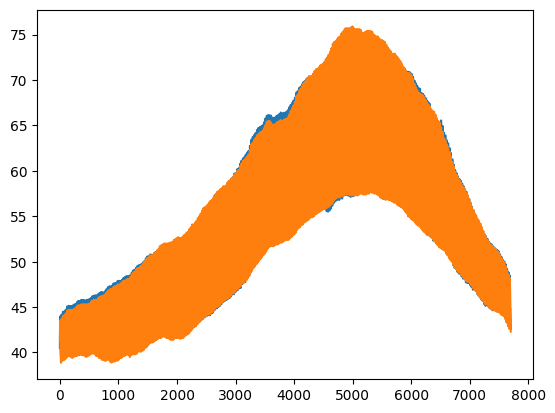

In [51]:
# Plot results for visual representation

plt.plot(train_results['Train Predictions'][:])
plt.plot(train_results['Actuals'][:])

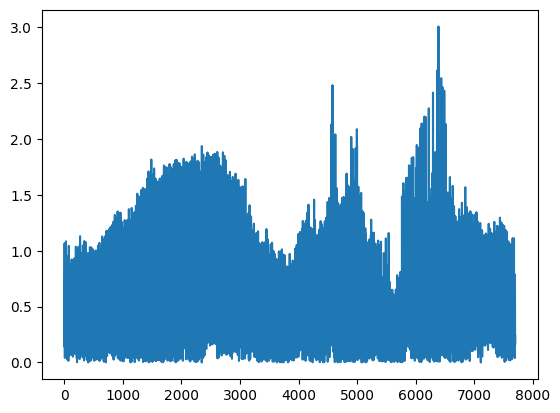

In [53]:
# Plotting deviation from actual temperatures

Error = abs(train_results['Actuals'][:] - train_results['Train Predictions'][:])
plt.plot(margin)

In [54]:
# Define function for plotting windows of time for predictions vs actuals

from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(predictions, y)

18/18 [==============================] - 0s 815us/step


(     Predictions  Actuals
 0      40.603794     40.0
 1      40.433834     39.8
 2      40.310276     39.6
 3      40.159191     39.5
 4      40.065895     39.6
 ..           ...      ...
 544    41.013359     40.7
 545    40.885769     40.5
 546    40.853882     40.2
 547    40.670250     40.0
 548    40.484566     39.7
 
 [549 rows x 2 columns],
 0.5240044313398575)

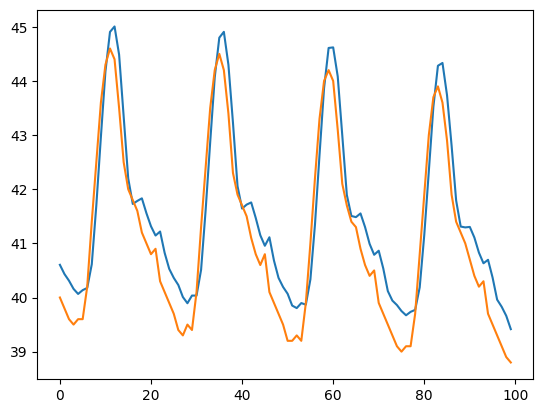

In [55]:
# Plotting window of 100 hours to have finer detail

plot_predictions1(model, X_test, y_test)